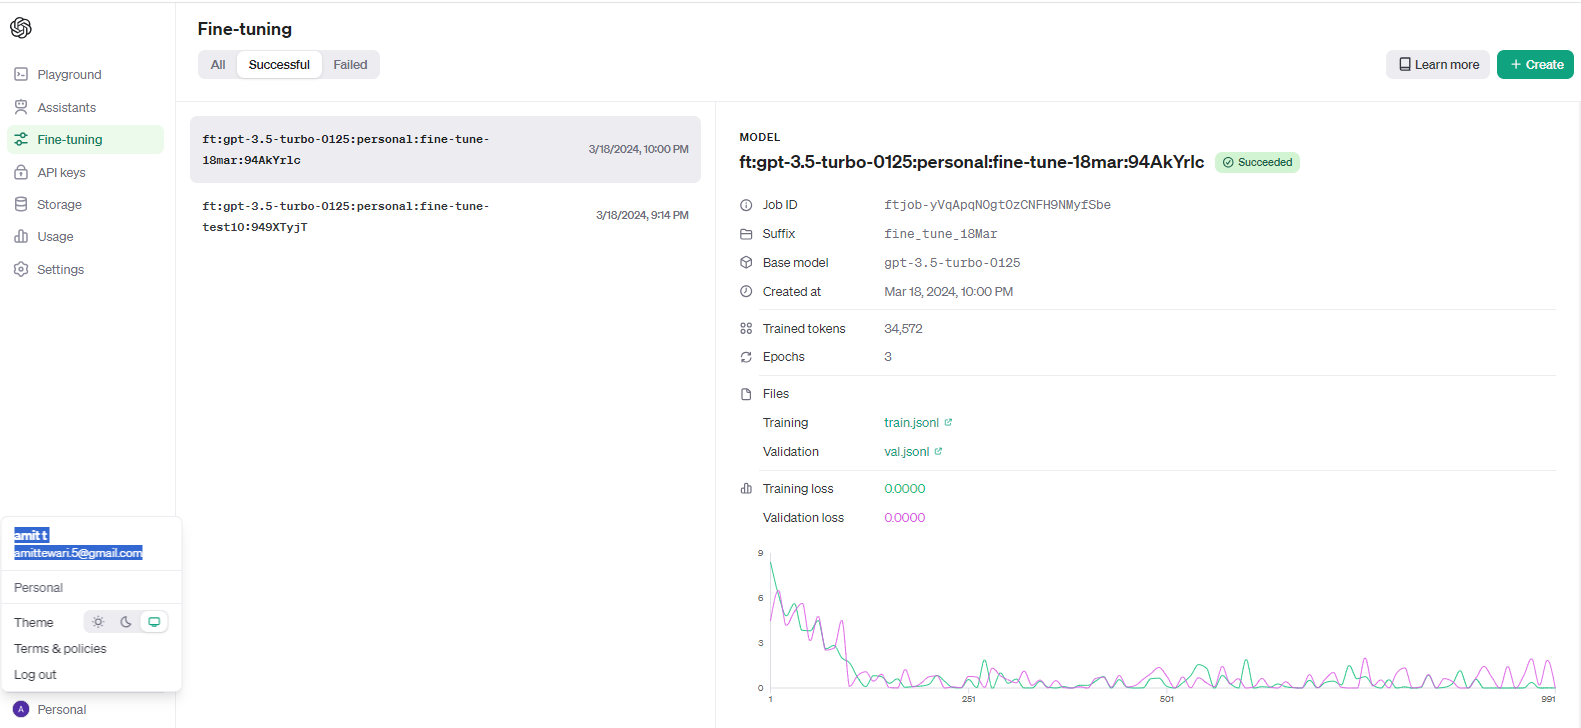

In [168]:
from IPython.display import Image
Image(filename='/content/sample_data/fine_tuning_gpt3.5.PNG')

In [1]:
!pip install openai
!pip install tiktoken

In [178]:
import openai
import pandas as pd
import numpy as np
import tiktoken
import json

In [3]:
f = open("/content/sample_data/OPENAI_API_KEY.txt", "r")
openai_api_key = f.read()
# print(openai_api_key)
client = openai.OpenAI(api_key=openai_api_key)

In [42]:
import pandas as pd
df_fine_tune = pd.read_csv("/content/sample_data/sample_fine_tuning_train.csv")
df_fine_tune.head(5)

,clause_text,clause_type
0,"Upon Changes in Capitalization, Merger, Asset ...",Adjustments
1,The SARs may be adjusted or terminated in any ...,Adjustments
2,The PSUs are subject to adjustment as provided...,Adjustments


In [43]:
def convert_to_gpt35_format(dataset):
    fine_tuning_data = []
    for _, row in dataset.iterrows():
        json_response = '{"clause_type": "' + row['clause_type'] + '"}'
        fine_tuning_data.append({
            "messages": [
                {"role": "user", "content": row['clause_text']},
                {"role": "assistant", "content": json_response}
            ]
        })
    return fine_tuning_data

In [141]:
dataset = pd.read_csv('/content/sample_data/fine_tuning_train.csv')
converted_data = convert_to_gpt35_format(dataset)
converted_data[0]['messages']

[{'role': 'user',
  'content': 'Upon Changes in Capitalization, Merger, Asset Sale, Dissolution or Liquidation .'},
 {'role': 'assistant', 'content': '{"clause_type": "Adjustments"}'}]

In [142]:
import json
json.loads(converted_data[0]['messages'][-1]['content'])

{'clause_type': 'Adjustments'}

In [143]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    converted_data,
    test_size=0.2,
    # stratify=dataset['clause_type'],
    random_state=42  # for reproducibility
)

In [144]:
type(train_data[0])

dict

In [145]:
print(len(converted_data))
print(len(train_data))
print(len(val_data))

417
333
84


In [146]:
# create JSONL file
def write_to_jsonl(data, file_path):
    with open(file_path, 'w') as file:
        for entry in data:
            json.dump(entry, file)
            file.write('\n')


training_file_name = "train.jsonl"
validation_file_name = "val.jsonl"

write_to_jsonl(train_data, training_file_name)
write_to_jsonl(val_data, validation_file_name)

In [147]:
training_file = client.files.create(
    file=open(training_file_name, "rb"), purpose="fine-tune"
)
validation_file = client.files.create(
    file=open(validation_file_name, "rb"), purpose="fine-tune"
)

print("Training file id:", training_file.id)
print("Validation file id:", validation_file.id)

Training file id: file-wZkcObG8zMYZRMhi35JuQdt0
Validation file id: file-0z3t89DyH2E2mztCigBxx3QW


In [148]:
suffix_name = "fine_tune_18Mar"

response = client.fine_tuning.jobs.create(
    training_file=training_file.id,
    validation_file=validation_file.id,
    model="gpt-3.5-turbo",
    suffix=suffix_name,
)
response

FineTuningJob(id='ftjob-yVqApqN0gtOzCNFH9NMyfSbe', created_at=1710779456, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-arpg3ET5cNNSX3qa0F29kUEl', result_files=[], status='validating_files', trained_tokens=None, training_file='file-wZkcObG8zMYZRMhi35JuQdt0', validation_file='file-0z3t89DyH2E2mztCigBxx3QW', user_provided_suffix='fine_tune_18Mar')

In [161]:
response = client.fine_tuning.jobs.retrieve("ftjob-yVqApqN0gtOzCNFH9NMyfSbe")
response

FineTuningJob(id='ftjob-yVqApqN0gtOzCNFH9NMyfSbe', created_at=1710779456, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal:fine-tune-18mar:94AkYrlc', finished_at=1710781661, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-arpg3ET5cNNSX3qa0F29kUEl', result_files=['file-VQvxD34xfJNZJfSVLW7dK1Ty'], status='succeeded', trained_tokens=34572, training_file='file-wZkcObG8zMYZRMhi35JuQdt0', validation_file='file-0z3t89DyH2E2mztCigBxx3QW', user_provided_suffix='fine_tune_18Mar')

In [162]:
client.fine_tuning.jobs.list(limit=10)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-yVqApqN0gtOzCNFH9NMyfSbe', created_at=1710779456, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal:fine-tune-18mar:94AkYrlc', finished_at=1710781661, hyperparameters=Hyperparameters(n_epochs=3, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-arpg3ET5cNNSX3qa0F29kUEl', result_files=['file-VQvxD34xfJNZJfSVLW7dK1Ty'], status='succeeded', trained_tokens=34572, training_file='file-wZkcObG8zMYZRMhi35JuQdt0', validation_file='file-0z3t89DyH2E2mztCigBxx3QW', user_provided_suffix='fine_tune_18Mar'), FineTuningJob(id='ftjob-ZYf4MF36wQhIQf2IGyvPcJJQ', created_at=1710776663, error=Error(code=None, message=None, param=None, error=None), fine_tuned_model='ft:gpt-3.5-turbo-0125:personal:fine-tune-test10:949XTyjT', finished_at=1710777006, hyperparameters=Hyperparameters(n_epochs=6, batch_size=1, learning_rate_mul

In [163]:
fine_tuned_model_id = response.fine_tuned_model
print("\nFine-tuned model id:", fine_tuned_model_id)


Fine-tuned model id: ft:gpt-3.5-turbo-0125:personal:fine-tune-18mar:94AkYrlc


# Test Finetuned Model

In [164]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def format_test(row):

    formatted_message = [
        {
            "role": "user",
            "content": row['clause_text']
        }
    ]
    return formatted_message


def predict(test_messages, fine_tuned_model_id):

    response = client.chat.completions.create(
        model=fine_tuned_model_id, messages=test_messages, temperature=0, max_tokens=50
    )

    return response.choices[0].message.content

In [165]:
def store_predictions(test_df, fine_tuned_model_id):

    print("fine_tuned_model_id",fine_tuned_model_id)
    test_df['Prediction'] = None

    for index, row in test_df.iterrows():
        test_message = format_test(row)
        prediction_result = predict(test_message, fine_tuned_model_id)
        test_df.at[index, 'Prediction'] = prediction_result
        test_df['Prediction_clause_type'] = test_df['Prediction'].apply(lambda x : json.loads(x)['clause_type'])
    test_df.to_csv("predictions.csv")

In [166]:
test_df = pd.read_csv("/content/sample_data/fine_tuning_test.csv")
store_predictions(test_df, fine_tuned_model_id)

fine_tuned_model_id ft:gpt-3.5-turbo-0125:personal:fine-tune-18mar:94AkYrlc


In [ ]:
# test_df['Prediction_clause_type'] = test_df['Prediction'].apply(lambda x : json.loads(x)['clause_type'])

In [197]:
test_df.head(10)

,clause_text,clause_type,Prediction,Prediction_clause_type
0,Any provision for the benefit of the Company c...,Waivers,"{""clause_type"": ""Waivers""}",Waivers
1,If a party waives any of its rights on any one...,Waivers,"{""clause_type"": ""Waivers""}",Waivers
2,Waiver by one party hereto or breach of any pr...,Waivers,"{""clause_type"": ""Waivers""}",Waivers
3,The provisions of this Article 13 supersede th...,Waivers,"{""clause_type"": ""No Other""}",No Other
4,The Company’s obligations under this Section 1...,Waivers,"{""clause_type"": ""Waivers""}",Waivers
5,ERISA means the Employee Retirement Income Sec...,Erisa,"{""clause_type"": ""ERISA""}",ERISA
6,Employee Retirement Income Security Act of 197...,Erisa,"{""clause_type"": ""ERISA""}",ERISA
7,Create or maintain any Pension Plans or incur ...,Erisa,"{""clause_type"": ""Pensions""}",Pensions
8,The Employee Retirement Income Security Act of...,Erisa,"{""clause_type"": ""ERISA""}",ERISA
9,Neither the Company nor any of its Subsidiarie...,Erisa,"{""clause_type"": ""Benefit Plans""}",Benefit Plans
